# **1. Introduction** <a class="anchor" id="1"></a>

In 2048 the **Newland** government decided that residents should start paying taxes in order to make the new city more financially sustainable. They decided to apply a binary tax rate in which for people with an income below or equal to the average the rate would be 15% of income and for the remaining people 30% of their income. The first phase of this process is to identify the people who belong to each class. To this end, a first income analysis was made to 32500 people older than 17 years old, from which the government intends to create a predictive model to apply to people on their way to Newland.
Several groups of data scientists (including our group) were invited to create a predictive model based on a dataset of 22400 observations. This model will be applied to 10100 new observations (the test dataset) from which the government knows the value of income.

## **1.2. Import packages**

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

## **1.3. Import data**

In [2]:
# read a xlsx file 'Train' from current directory into DataFrame and save it to a variable called 'data'
data = pd.read_excel(os.path.join(os.getcwd(),'Train.xlsx'))

In [3]:
#check the top of the datframe to ensure it loaded correctly
data.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


# **2. Data preprocessing** <a class="anchor" id="3"></a>

In [4]:
data.describe(include = ['O'])

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Employment Sector,Role
count,22400,22400,22400,22400,22400,22400,22400,22400,22400
unique,16074,11257,5,7,6,40,16,9,15
top,Mr. Christian Manning,"August 15,2025",Europe,Married,Wife,Northbury,Professional School,Private Sector - Services,Professor
freq,4,9,19111,10219,9012,20074,7232,15599,2849


In [5]:
# find all unique values for categorical variables
{item: data[item].unique() for item in data if data[item].dtype=='O'}

{'Name': array(['Mr. Adam Glover', 'Mr. Cameron McDonald', 'Mr. Keith Davidson',
        ..., 'Mrs. Lisa Alsop', 'Miss Amelia Walker', 'Mr. Joseph Murray'],
       dtype=object),
 'Birthday': array([' July 1,2003', ' January 25,2006', ' May 10,2009', ...,
        ' March 11,2008', ' April 5,1984', ' August 20,1987'], dtype=object),
 'Native Continent': array(['Europe', 'Africa', 'Asia', 'America', 'Oceania'], dtype=object),
 'Marital Status': array(['Married', 'Single', 'Married - Spouse Missing', 'Divorced',
        'Separated', 'Widow', 'Married - Spouse in the Army'], dtype=object),
 'Lives with': array(['Wife', 'Other Family', 'Children', 'Other relatives', 'Alone',
        'Husband'], dtype=object),
 'Base Area': array(['Northbury', 'Auchenshuggle', 'Sharnwick', 'Laewaes',
        'MillerVille', '?', 'Fanfoss', 'Wigston', "Knife's Edge",
        'Aerilon', 'Watford', 'Lanercost', 'Bellmoral', 'Marnmouth',
        'Bellenau', 'Butterpond', 'Laenteglos', 'Tranmere', 'Eelry',
       

In [6]:
df = data.copy()
#to make it easier to work with columns
df.columns = df.columns.str.replace(' ', '_', regex=True)
#converting column datatype to str to use string manipulation
df['Name'] = df['Name'].astype(str)
#first string before '.'
df['Name_gender'] = df['Name'].str.split('.').str[0]
#in order to don't miss out on anyone that hasnt a Mr or Mrs 
df['Name_gender'] = df['Name_gender'].replace(' ', '.', regex=True)
df['Name_gender'] = df['Name_gender'].str.split('.').str[0]

#  female and male
def binary_gender(x):
    if str(x) == 'Mrs' or str(x) == 'Miss':
        return 'Female'
    else:
        return 'Male'
df['Name_gender'] = df['Name_gender'].apply(binary_gender)

df.rename(columns = {'Name_gender':'Sex'}, inplace = True)

In [7]:
#converting Birthday to age(int), current year is 2048
df['Birthday'] = df['Birthday'].astype(str)
df['Age'] = df['Birthday'].str.split(',').str[1]
df['Age'] = df["Age"].apply(lambda x : 2048 - int(x))

In [8]:
# delete un-necessary columns
df = df.drop(['Name', 'Birthday', 'CITIZEN_ID'], axis=1)

In [9]:
#what is it for?
df = df[np.insert(df.columns[:-1].values, 0, df.columns[-1], axis=None)]

In [10]:
# combine education level into highest level of education
edu_level = ['Middle School', 'High School', 'Professional School', 'Bachelors', 'Masters']
for edu in edu_level:
    mask = df['Education_Level'].str.contains(edu ,na = False)
    df.loc[mask, 'Education_Level'] = df.loc[mask, 'Education_Level'].apply(lambda x: edu)

In [11]:
#group by public sector/private/self
def grouping_employment(x):
    if str(x) == 'Private Sector - Services ' or str(x) == 'Private Sector - Others':
        return 'Private Sector'
    elif str(x) == 'Public Sector - Others' or str(x) == 'Public Sector - Government':
        return 'Public Sector'
    elif str(x) == 'Self-Employed (Individual)' or str(x) == 'Self-Employed (Company)':
        return 'Self-Employed'
    elif str(x) == 'Unemployed' or str(x) == 'Never Worked':
        return 'Unemployed'
    else:
        return np.nan
df['Employment_Sector'] = df['Employment_Sector'].apply(grouping_employment)

## Missing values

In [12]:
#replace '?' with NaN value to easily detect
df.replace( '\?', np.nan, regex=True, inplace = True)

In [13]:
# missing values in each feature
df.isna().sum().loc[df.isna().sum() > 0].sort_values(ascending = False)

Role                 1271
Employment_Sector    1264
Base_Area             395
dtype: int64

In [14]:
# Fill NaN values in categorical features using mode
contain_NA_feats = ['Base_Area', 'Employment_Sector', 'Role']
modes = df[contain_NA_feats].mode().loc[0]
df.fillna(modes,inplace = True)

# Data cleaning

In [15]:
# people in data have to be older than 17 years old, let's check 
df.groupby('Role').Age.agg(['min', 'max'])

,min,max
Role,,
Administratives,17,90
Agriculture and Fishing,17,90
Army,23,46
Cleaners & Handlers,17,90
Household Services,17,77
IT,17,73
Machine Operators & Inspectors,17,90
Management,17,90
Other services,17,90


In [16]:
df[df['Role']=='Professor'].Education_Level.unique()

array(['PhD', 'Bachelors', 'Professional School', 'High School',
       'Masters', 'Middle School', 'Primary School', 'Preschool'],
      dtype=object)

## Separate numercial & categorical variables; independent & dependent variables

In [17]:
# Separate Dependent & Independent feature:
df_Y = df.loc[:,'Income']
df_X = df.drop('Income', axis = 1)
# indicate categorical & numbercial feature
numercial = [feat for feat in df_X.columns if df_X[feat].dtype!='O']
categorical = [feat for feat in df_X.columns if df_X[feat].dtype =='O']

## Outliers

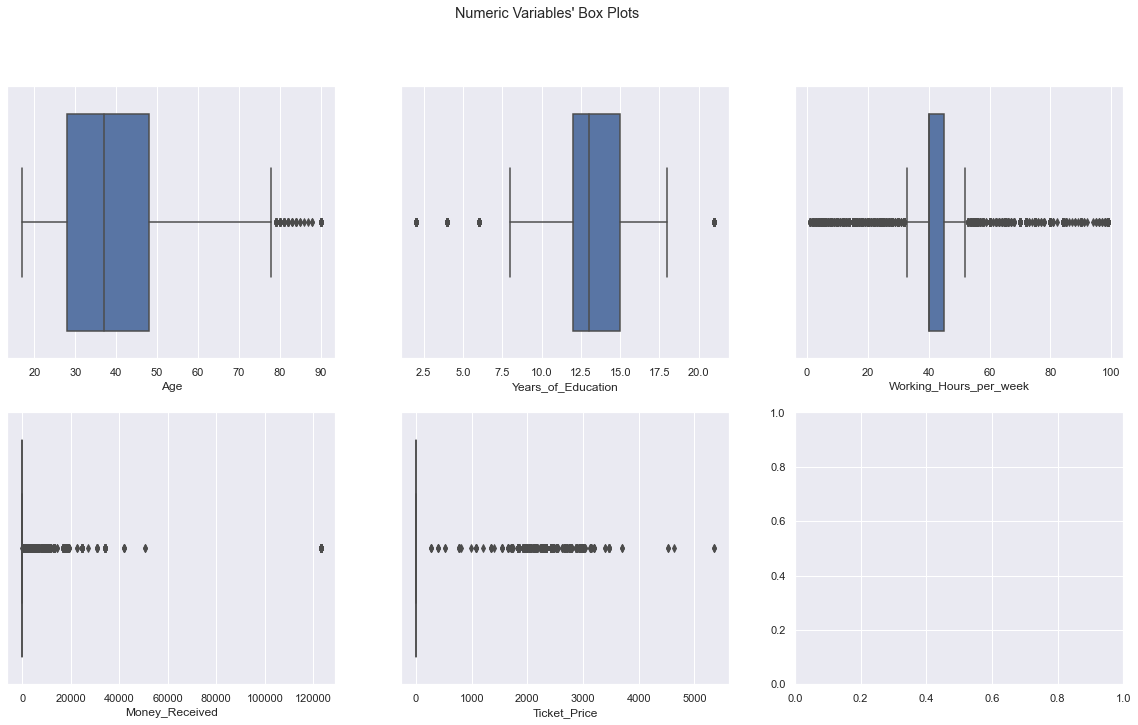

In [18]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(numercial) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numercial): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

## Explore data by each predefined groups (A, B & C)

In [19]:
#   Group A -  The majority of the people (volunteers) were carefully chosen through an extensive selection process
#   Group B -  More than 2500 people were payed to participate in the mission (those were people who have been considered 
#              by the state has essential people to have on an initial stage)
#   Group C -  Around 1500 people payed to participate in the mission 
#             (those who were rejected in a selection process but entered by making a money offer)

#probably relative to ticket price(GroupC) and money_received(GroupB) --> we need to check if the numbers are in order with info

# Separate data of group A & B & C
data_groupA = df[(df['Money_Received'] == 0) & (df['Ticket_Price'] == 0)].drop(['Money_Received','Ticket_Price'],axis = 1)
data_groupB = df[df['Money_Received'] != 0].drop('Ticket_Price',axis = 1)
data_groupC = df[df['Ticket_Price'] != 0].drop('Money_Received', axis = 1)

### Group A

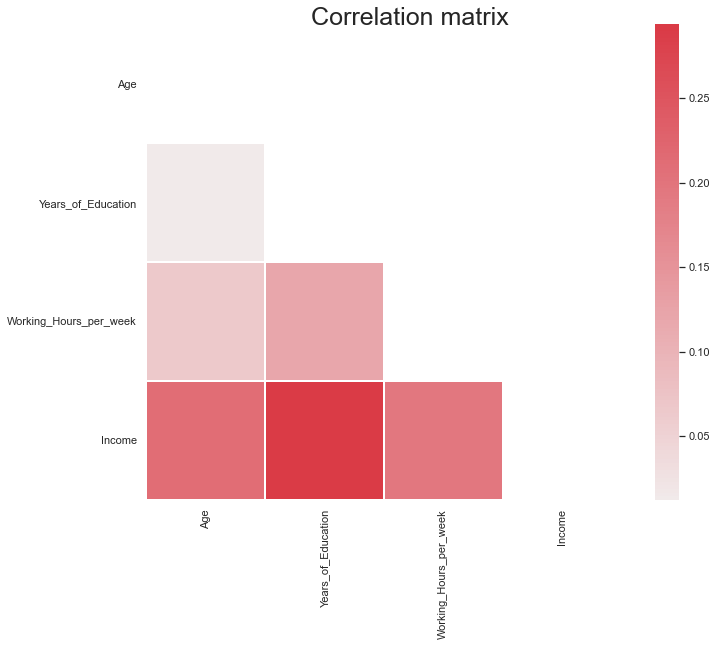

In [20]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupA.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

### Group B

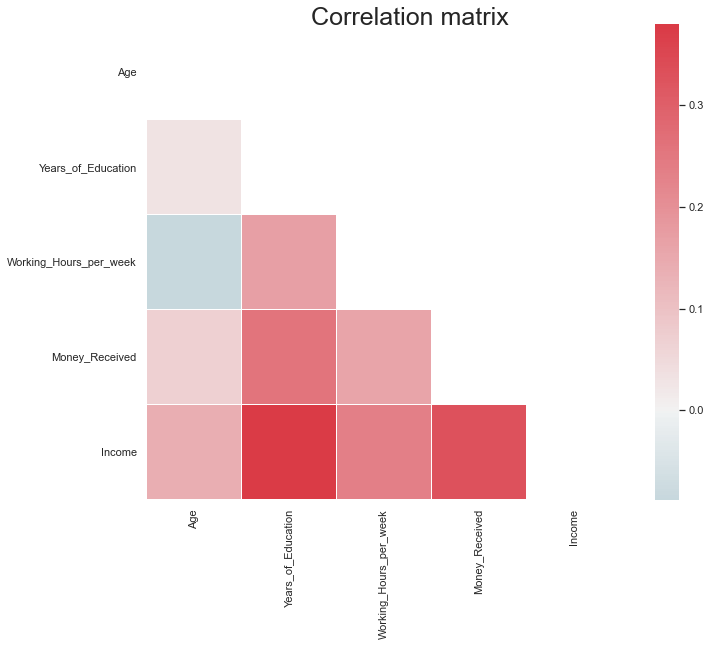

In [21]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupB.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

### Group C

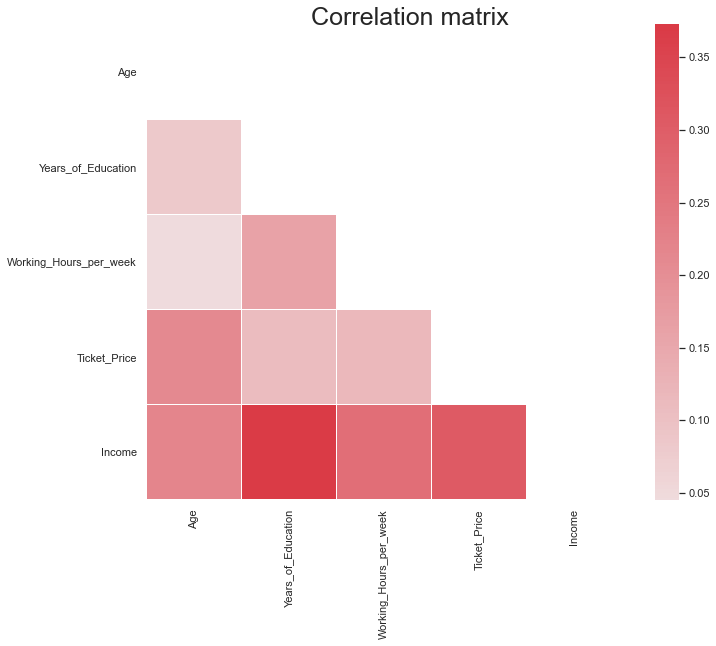

In [22]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupC.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

## Explore categorical variable

In [23]:
categorical

['Native_Continent',
 'Marital_Status',
 'Lives_with',
 'Base_Area',
 'Education_Level',
 'Employment_Sector',
 'Role',
 'Sex']

<ipython-input-24-78693255c406>:13: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(hspace=1)


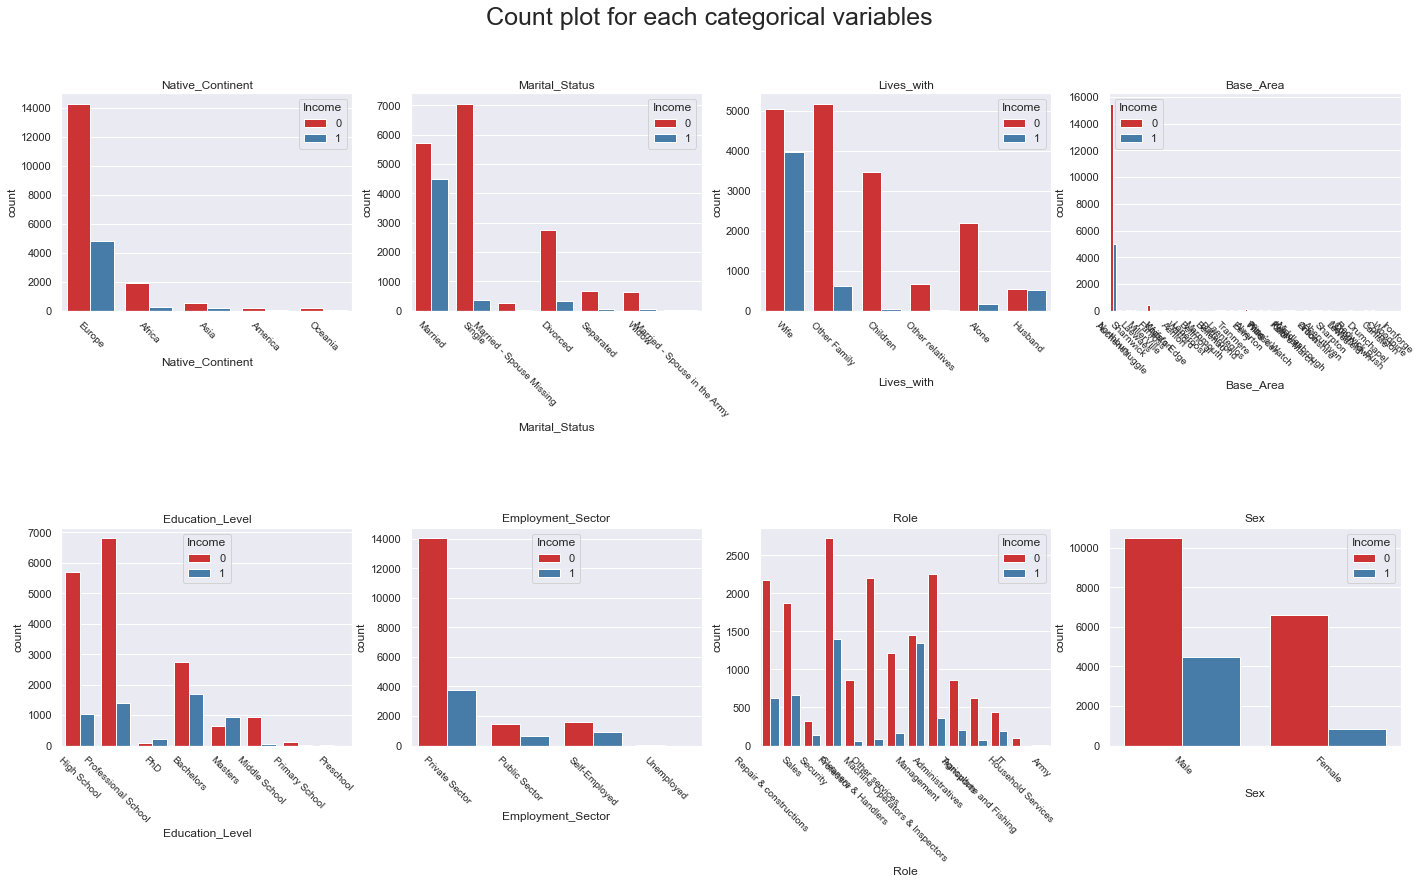

In [24]:
# Plot transformed data
sns.set()
fig, axes = plt.subplots(2,4, constrained_layout=True, figsize=(24,12))

fig.suptitle("Count plot for each categorical variables\n", fontsize=25)

for col, ax in zip(df[categorical].columns, axes.flatten()):
    sns.countplot(x=col, hue="Income", data=df, palette="Set1",ax=ax)
    ax.tick_params(axis='x',labelsize = 'small', labelrotation=-45) 
    ax.set_title(col)
    
# Just appear labels on outside axes
fig.subplots_adjust(hspace=1)
plt.show()

# **4. Modeling** <a class="anchor" id="4"></a>

## Split data for modelling

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, stratify = df_Y, random_state=None)

## Apply OneHotEncoder to categorical data:

In [26]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(X_train[categorical])

ohc_feat_names = ohc.get_feature_names()

ohc_df = pd.DataFrame(ohc_feat, index=X_train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?

# transfrom validation dataset
ohc_feat_test = ohc.transform(X_test[categorical])
ohc_df_test = pd.DataFrame(ohc_feat_test, index=X_test.index, columns=ohc_feat_names)

## Apply Min-Max scaler to numercial features:

In [27]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
X_train[numercial] = scaler.fit_transform(X_train[numercial])
X_test[numercial] = scaler.transform(X_test[numercial])
X_train[numercial].head()

<ipython-input-27-fd1428d31a71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numercial] = scaler.fit_transform(X_train[numercial])
C:\Users\mi\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-27-fd1428d31a71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,Age,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price
13601,0.219178,0.578947,0.397959,0.039082,0.0
20153,0.027397,0.578947,0.397959,0.000000,0.0
21446,0.136986,0.578947,0.479592,0.000000,0.0
16478,0.027397,0.526316,0.295918,0.000000,0.0
8233,0.123288,0.736842,0.500000,0.000000,0.0


In [28]:
# Reassigning df to contain ohc variables
X_train = pd.concat([X_train.drop(columns=categorical), ohc_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical), ohc_df_test], axis=1)

In [29]:
X_train

,Age,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price,x0_America,x0_Asia,x0_Europe,x0_Oceania,x1_Married,...,x6_IT,x6_Machine Operators & Inspectors,x6_Management,x6_Other services,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports,x7_Male
13601,0.219178,0.578947,0.397959,0.039082,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
20153,0.027397,0.578947,0.397959,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
21446,0.136986,0.578947,0.479592,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16478,0.027397,0.526316,0.295918,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8233,0.123288,0.736842,0.500000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15628,0.356164,0.578947,0.602041,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15386,0.328767,0.526316,0.397959,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16092,0.383562,0.526316,0.397959,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12715,0.027397,0.526316,0.489796,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [30]:
X_test

,Age,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price,x0_America,x0_Asia,x0_Europe,x0_Oceania,x1_Married,...,x6_IT,x6_Machine Operators & Inspectors,x6_Management,x6_Other services,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports,x7_Male
15071,0.041096,0.578947,0.142857,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4784,0.301370,0.578947,0.602041,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2425,0.589041,0.526316,0.397959,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13743,0.575342,0.684211,0.397959,0.0,0.000000,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11841,0.109589,0.684211,0.193878,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,0.000000,0.526316,0.193878,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8085,0.027397,0.526316,0.153061,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14024,0.273973,0.210526,0.397959,0.0,0.000000,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3285,0.013699,0.578947,0.397959,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

C:\Users\mi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Measure the accuracy of train set

In [32]:
y_train_predicted = log_model.predict(X_train)

In [33]:
confusion_matrix(y_train, y_train_predicted)

array([[11161,   801],
       [ 1582,  2136]], dtype=int64)

In [34]:
accuracy_score(y_train, y_train_predicted)

0.8480229591836734

In [35]:
precision_score(y_train, y_train_predicted)

0.7272727272727273

### Measure the accuracy of test set

In [36]:
y_predicted = log_model.predict(X_test)

In [37]:
confusion_matrix(y_test, y_predicted)

array([[4774,  353],
       [ 725,  868]], dtype=int64)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [39]:
accuracy_score(y_test, y_predicted)

0.8395833333333333

In [40]:
precision_score(y_test, y_predicted)

0.7108927108927109

## Support Vector Classification

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [42]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
lin_clf = SVC(kernel='linear')
poly_clf = SVC(kernel='poly')
rbf_clf = SVC(kernel='rbf')
sigm_clf = SVC(kernel='sigmoid')

In [43]:
lin_clf.fit(X_train ,y_train)
preds = lin_clf.predict(X_test)

#F1 score

print(f1_score(y_test, preds,average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.7568160565628921
0.840625
0.8318935739537006


In [45]:
poly_clf.fit(X_train ,y_train)
preds = poly_clf.predict(X_test)

#F1 score

print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.7356929047513452
0.830654761904762
0.8190084964048145


In [47]:
rbf_clf.fit(X_train ,y_train)
preds = rbf_clf.predict(X_test)

#F1 score

print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.7371666092368772
0.8308035714285714
0.8196679865456399


In [46]:
sigm_clf.fit(X_train ,y_train)
preds = sigm_clf.predict(X_test)

#F1 score

print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.6759343798460157
0.7691964285714286
0.7673596448101235


In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}

In [50]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  21.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  21.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  19.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  20.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  22.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=  15.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=  18.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=  16.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.3s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=  20.8s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=  21.2s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=  25.9s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=  27.6s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=  27.7s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=  22.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 24.0min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

In [51]:
grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[4813  314]
 [ 751  842]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5127
           1       0.73      0.53      0.61      1593

    accuracy                           0.84      6720
   macro avg       0.80      0.73      0.76      6720
weighted avg       0.83      0.84      0.83      6720

